**WARNING ! THE MEMBRANE SHOULD BE ALIGNED ON THE Z AXIS FIRST ! NO MEMBRANE ROTATION!!!**

In [1]:
WORKDIR = "/Users/thibault/Documents/WORK/simu/mahmoud/ForThibault"
TRAJ = f"{WORKDIR}/traj.xtc"
TOPOL = f"{WORKDIR}/topol.pdb"

membraneLayerResidue = "residue 129 to 256"
proteinSelection="protein"


TODO :

Find automatic upper and lower:
1. calculate the average Z of all P
2. Get Z of every lipid
3. Z > average Z means upper leaflet....

In [2]:
import mdtraj as md
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nglview as nv
import pandas as pd

In [3]:
traj = md.load(TRAJ, top=TOPOL)

In [4]:
def calc_depth(traj, membraneLayerResidue, proteinSelection="protein"):

    #1. Averaging all P Z coordinate, along the trajectory
    Pplan = traj.top.select(f"({membraneLayerResidue}) and symbol P") # Get all the phosphate of the selected lipids
    average_phosphate = np.mean(traj.atom_slice(Pplan).xyz,axis=1) #calculate the average of all coordinates
    average_Z_phosphate = np.array([x[2] for x in average_phosphate]) #Average on Z only for every frames

    #2. Averagine the protein now.
    protSelection = traj.atom_slice(traj.top.select(f"{proteinSelection} and name CA")) #Get only the protein (AND CA)
    index = [x.residue.resSeq for x in protSelection.top.atoms] #Get the Residue number
    average_protCA = np.mean(protSelection.xyz,axis=1) #Average of all CA atoms in every frames
    average_Z_CA = np.array([x[2] for x in  average_protCA]) #Average of Z only atoms in every frames

    allz = protSelection.xyz[:,:,2]

    #nframe = protSelection.n_frames
    depth_res_time = []
    for i in range(allz.shape[1]):
        depth = average_Z_phosphate - allz[:,i]
        depth_res_time.append(depth)
    depth_res_time = np.asarray(depth_res_time)

    depth_res_time
    df = pd.DataFrame(depth_res_time, index=index)
    df = df*10

    return (df)

    


In [5]:
all_dataframe = calc_depth(traj, membraneLayerResidue, proteinSelection)

<AxesSubplot:>

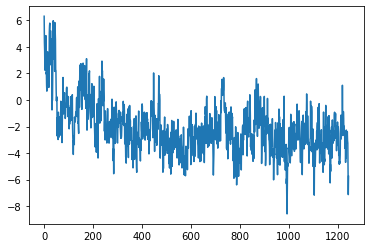

In [49]:
def get_depth_for_residue(data, residueNumber):
    return data.loc[residueNumber,]

df474 = get_depth_for_residue(all_dataframe, 474)
df474.plot()

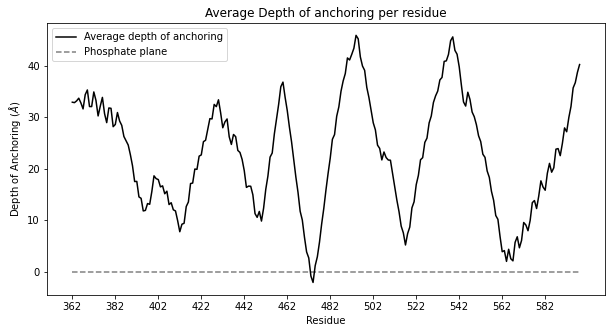

In [54]:
def average_in_time(data, title="", tick_every=10):
    data = data.mean(axis=1).reset_index()
    data = data.rename(columns={"index":"Residue", 0:"Depth"})
    fig, ax = plt.subplots(figsize=(10,5))

    minres = data.Residue.min()
    maxres = data.Residue.max()
    graph = sns.lineplot(x="Residue", y="Depth", data=data, color="black", ax=ax)
    graph.set(ylabel=r"Depth of Anchoring ($\AA$)", xlabel="Residue", title=title)
    hline = plt.hlines(y=0, xmin=minres, xmax = maxres, color="gray", linestyles='dashed')

    graph.set_xticks(range(minres, maxres, 20))

    #Now the legend
    plt.legend(labels=["Average depth of anchoring","Phosphate plane"])


    
    
average_in_time(all_dataframe, title="Average Depth of anchoring per residue")

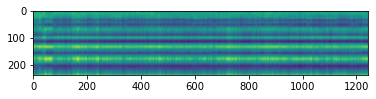

In [8]:
plt.imshow(all_dataframe.values)